In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
chicago = pd.read_csv('/content/drive/MyDrive/final_csv/crime.csv')

In [4]:
features = [
    'Year', 'Month', 'Primary Type',
    'Description', 'Community Area',
    'Latitude', 'Longitude', 'Offense Level Median',
    'Dist_to_Nearest_HighRisk','min_distance_to_police',
    'Location Description'

]

target = 'Arrest'

In [5]:
ml_data = chicago[features + [target]].copy()

In [6]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le_dict = {}
for col in features:
    if ml_data[col].dtype == 'object':
        le = LabelEncoder()
        ml_data[col] = le.fit_transform(ml_data[col])
        le_dict[col] = le

In [7]:
# X, y 분리
X_data = ml_data.drop(columns=[target])
y_data = ml_data[target]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.3,
                                                    stratify=y_data,
                                                    random_state=42)

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [10]:
from collections import Counter

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({False: 4322548, True: 1471122})
After SMOTE: Counter({False: 4322548, True: 4322548})


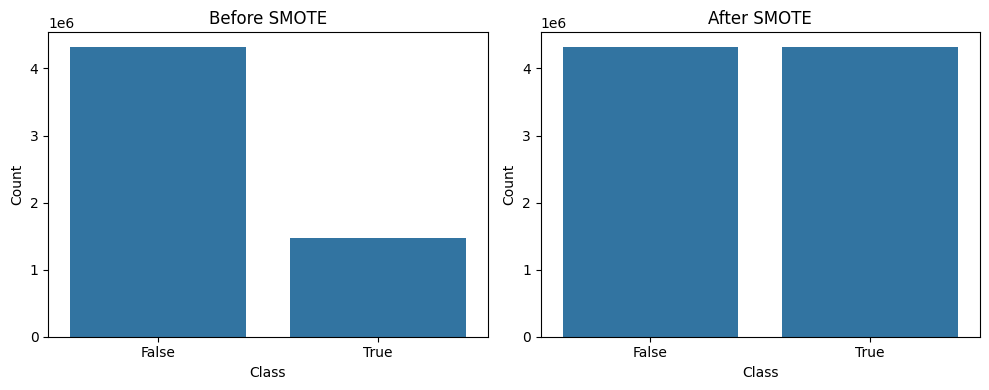

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data 준비
before = pd.Series(y_train).value_counts().sort_index()
after = pd.Series(y_resampled).value_counts().sort_index()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=before.index, y=before.values, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.barplot(x=after.index, y=after.values, ax=axes[1])
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

- 샘플만 뽑아 진행

In [12]:
from sklearn.model_selection import train_test_split

# SMOTE 이후 훈련 데이터 중 일부만 샘플링
X_sample, _, y_sample, _ = train_test_split( # _는 테스트셋 버리기 위한 용도
    X_resampled, y_resampled,
    train_size=0.1,
    stratify=y_resampled,
    random_state=42
)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# 모델 설정
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# 미니멀 파라미터 탐색 공간
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# F1 스코어 기준으로 평가
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 학습 (샘플 데이터 사용!)
grid_search.fit(X_sample, y_sample)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

In [14]:
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best F1 Score: 0.8286352350730627


In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
best_rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_resampled, y_resampled)

y_pred = best_rf.predict(X_test)

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

정확도 (Accuracy): 0.8744962750734796

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.91      0.92      0.92   1852521
        True       0.76      0.74      0.75    630481

    accuracy                           0.87   2483002
   macro avg       0.84      0.83      0.83   2483002
weighted avg       0.87      0.87      0.87   2483002


혼동 행렬 (Confusion Matrix):
 [[1706760  145761]
 [ 165865  464616]]


In [18]:
from sklearn.model_selection import train_test_split

# 훈련 데이터에서 10%만 샘플링
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.1,        # 10%
    stratify=y_train,
    random_state=42
)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# 모델 정의
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# 파라미터 후보
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV 실행
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_sample, y_sample)

# 결과 출력
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best F1 Score: 0.7511842001934962


In [28]:
# 전체 데이터로 재학습
best_rf_final = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
best_rf_final.fit(X_train, y_train)

# 예측 및 평가
y_pred = best_rf_final.predict(X_test)

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

정확도 (Accuracy): 0.8951116430836544

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.89      0.98      0.93   1852521
        True       0.92      0.65      0.76    630481

    accuracy                           0.90   2483002
   macro avg       0.90      0.81      0.85   2483002
weighted avg       0.90      0.90      0.89   2483002


혼동 행렬 (Confusion Matrix):
 [[1815105   37416]
 [ 223022  407459]]


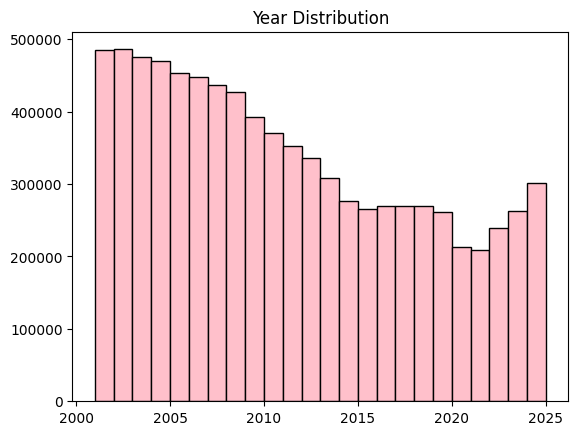

In [20]:
# 히스토그램
plt.hist(chicago['Year'], bins=range(2001, 2026), edgecolor='black', color='pink')
plt.title('Year Distribution')
plt.show()

In [21]:
# 연도별 범죄 수 계산
annual_crime_counts = chicago['Year'].value_counts().sort_index()

# 출력
print(annual_crime_counts)

Year
2001    484273
2002    485910
2003    475918
2004    469388
2005    453735
2006    448160
2007    437067
2008    427145
2009    392806
2010    370509
2011    351999
2012    336319
2013    307568
2014    275854
2015    264818
2016    269886
2017    269156
2018    268985
2019    261484
2020    212449
2021    209330
2022    239575
2023    262836
2024    257719
2025     43783
Name: count, dtype: int64


In [22]:
# 체포된 사건 수
total_arrests = chicago['Arrest'].sum()

# 전체 사건 수
total_cases = len(chicago)

# 체포율 계산
arrest_rate = total_arrests / total_cases

print(f"총 체포율: {arrest_rate:.2%}")


총 체포율: 25.39%


In [23]:
a = pd.read_csv('/content/drive/MyDrive/final_csv/chicago_with_distance.csv')

In [25]:
a.shape

(8276672, 31)

In [26]:
b= pd.read_csv('/content/drive/MyDrive/final_csv/최종데이터/최종데이터/chicago_crime_final.csv')

In [27]:
b.shape

(8276672, 26)